In [15]:
%reset -f
%load_ext autoreload
%autoreload 2

import sys
import os

sys.path.append(os.path.join(os.path.pardir, 'code'))
figdir = os.path.join(os.path.pardir, 'figures')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import itertools

from simulator import LinearSystemSimulator
from observability import ObservabilityMatrix
from eiso import optimize_matrix_rows_to_state, optimize_matrix_rows_to_states, optimize_matrix_rows_to_states_iterative
from eiso import analytical_observability_gramian, calculate_condition_number

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Define system

In [16]:
k1 = 1
k2 = k1
m = 1
b = 1

A = np.array([[0.0, 1.0, 0.0],
              [-(k1 + k2)/b, 0.0, k1/m],
              [k1/b, 0.0, -k1/b]])

B = np.array([[0.0],
              [1.0/m],
              [0.0]])

C = np.array([[1.0, 0.0, 0.0],
              [1.0, 1.0, 1.0],
              [0.0, 1.0, 1.0]])

D = np.zeros((C.shape[0], 1))

# Get sizes
n_state = A.shape[0]
n_output = C.shape[0]

### Analytical observability matrix

In [17]:
_, Oa = analytical_observability_gramian(A, C, 'continuous', use_observability_matrix=True)
pd.DataFrame(Oa)

,0,1,2
0,1.0,0.0,0.0
1,1.0,1.0,1.0
2,0.0,1.0,1.0
3,0.0,1.0,0.0
4,-1.0,1.0,0.0
5,-1.0,0.0,0.0
6,-2.0,0.0,1.0
7,-2.0,-1.0,1.0
8,0.0,-1.0,0.0


### Define system simulator object

In [18]:
sys = LinearSystemSimulator(A, B, C, D,
                            system_type='continuous',
                            measurement_type='linear')

### Simulate

[0.85 0.   0.  ]


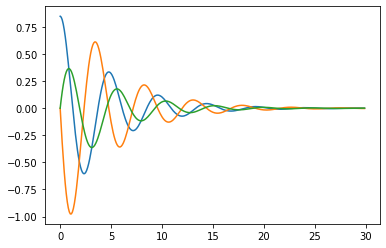

In [19]:
# Set time & input(s)
T = 30 # total time [s]
fs = 10 # sampling rate [hz]
ts = 1 / fs # time step [s]

# Simulation time
tsim = np.arange(0, T, ts).T
n_point = tsim.shape[0]

# Simulation input
usim = np.zeros((len(tsim), 1))

# Initial conditions
x0 = 0.85*np.squeeze(np.ones((1,n_state)))
x0[1:] = 0
print(x0)

# Simulate
nominal_state, _ = sys.simulate(x0, tsim, usim)

# Plot
plt.plot(nominal_state['t'], nominal_state['x'])
plt.show()

### Calculate empirical observability matrix

In [27]:
w = 100 # window size
Obsv = ObservabilityMatrix(sys, nominal_state['t'], nominal_state['x'], nominal_state['u'])
Oe, deltay = Obsv.calculate_O(x0, tsim[0:w], usim[0:w], eps=0.001)
pd.DataFrame(Oe)

,0,1,2
0,1.000000,0.000000,0.000000
1,1.000000,1.000000,1.000000
2,0.000000,1.000000,1.000000
3,0.990179,0.099671,0.004829
4,0.890508,1.094679,1.004667
...,...,...,...
295,0.139416,0.076555,-0.036755
296,0.002482,0.079037,0.021141
297,0.130581,0.010911,-0.051970
298,0.119670,0.089521,-0.025329


### Calculate empirical observability Gramian from empirical observability matrix

In [28]:
We = Oe.T @ Oe
pd.DataFrame( np.round(We, 3))

,0,1,2
0,50.381,-9.423,-29.188
1,-9.423,50.534,40.843
2,-29.188,40.843,50.833


In [29]:
CN_We = calculate_condition_number(We, square=False)
CN_We

22.838916016221432

### Calculate analytical observability Gramian

In [30]:
Wa = analytical_observability_gramian(A, C, 'continuous', use_observability_matrix=False)
pd.DataFrame(Wa)

,0,1,2
0,5.0,-1.0,-3.0
1,-1.0,5.0,4.0
2,-3.0,4.0,5.0


In [31]:
CN_Wa = calculate_condition_number(Wa, square=False)
CN_Wa

23.50446969207272

### Collect rows for each combination of states

In [32]:
all_states = np.arange(0, n_state, 1)
comb_sizes = all_states.copy()
states_of_interest = []
for r in comb_sizes: # every different size combination
    combs = itertools.combinations(all_states, r + 1)
    for c in combs:
        s = np.array(c)
        slist = [[i] for i in s]
        states_of_interest.append(slist)
        print(s)

[0]
[1]
[2]
[0 1]
[0 2]
[1 2]
[0 1 2]


In [33]:
states_of_interest

[[[0]], [[1]], [[2]], [[0], [1]], [[0], [2]], [[1], [2]], [[0], [1], [2]]]

### Run E-ISO on each state combination

In [34]:
alpha = 1e-2
beta = 1e-3
sigma = 1e-6

norm = None
state_iter_data = []
for n, s in enumerate(states_of_interest):
    print(s)
    out = optimize_matrix_rows_to_states_iterative(Oe,
                                                   states=s,
                                                   alpha=alpha,
                                                   beta=beta,
                                                   sigma=sigma,
                                                   include_constraints=False,
                                                   norm=norm)
    out['comb'] = n
    state_iter_data.append(out)

[[0]]
[[1]]
[[2]]
[[0], [1]]
[[0], [2]]
[[1], [2]]
[[0], [1], [2]]


### Check if states were reconstructed for each combination

In [35]:
for e in state_iter_data:
    print('States:', e['states'])
    print(np.round(e['ejo_iter'][-1], 3))
    print()

States: [[0]]
[[1. 0. 0.]]

States: [[1]]
[[-0.  1.  0.]]

States: [[2]]
[[-0.  0.  1.]]

States: [[0], [1]]
[[1. 0. 0.]
 [0. 1. 0.]]

States: [[0], [2]]
[[ 1.  0. -0.]
 [ 0.  0.  1.]]

States: [[1], [2]]
[[-0.  1.  0.]
 [-0.  0.  1.]]

States: [[0], [1], [2]]
[[ 1. -0. -0.]
 [-0.  1.  0.]
 [ 0. -0.  1.]]



### Set line colors for plot

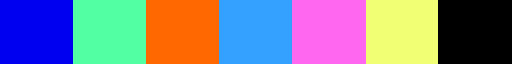

In [36]:
from matplotlib.colors import ListedColormap

crange = 0.8
cmap = cm.get_cmap('jet')
cmap_state = cmap(np.linspace(0.1, crange, n_state))[:,-0:n_state]

comb_states = states_of_interest[n_state:]
cmap_state_comb = []
for c in comb_states:
    csub = cmap_state[c, :]
    cnew = np.sum(csub, axis=0)
    cnew = cnew / csub.shape[0]
    cnew = cnew / np.max(cnew)
    cmap_state_comb.append(cnew)
    
cmap_state_comb = np.vstack(cmap_state_comb)
cmap_all = np.vstack((cmap_state, cmap_state_comb))
cmap_all[-1] = np.array([0, 0, 0])

ListedColormap(cmap_all)

### Plot

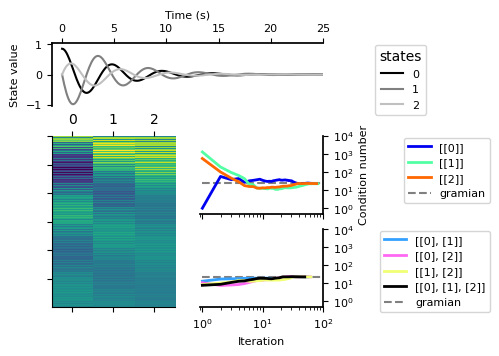

In [43]:
fig, ax = plt.subplot_mosaic("AA;BC;BD", figsize=(3.5, 3.5), dpi=100)

color_y = ('black', 'gray', 'silver')
for p in range(nominal_state['y'].shape[1]):
    ax['A'].plot(nominal_state['t'], nominal_state['x'][:,p], color=color_y[p], label=p)
    
ax['A'].legend(loc='upper right', title='states', fontsize=8, bbox_to_anchor=(1.4, 1.05))

ax['A'].tick_params(axis='both', which='major', labelsize=8)
ax['A'].tick_params(axis='both', which='minor', labelsize=8)
ax['A'].set_ylabel('State value', fontsize=8)
ax['A'].set_xlabel('Time (s)', fontsize=8)

ax['A'].set_xlim([-1, 25])
# ax['A'].set_xticks(np.arange(0, 30.01, 5))

ax['A'].set_ylim([-1.05, 1.05])
ax['A'].xaxis.tick_top()
ax['A'].xaxis.set_label_position('top')
ax['A'].spines[['bottom', 'right']].set_visible(False)

for side in ['top','bottom','left','right']:
    ax['A'].spines[side].set_linewidth(1.25)

box = ax['A'].get_position()
box.y0 = box.y0 + 0.04
ax['A'].set_position(box)

ax['B'].spines[['top', 'right']].set_visible(False)

ax['B'].matshow(Oe, aspect='auto')

for n, S in enumerate(state_iter_data):
    if n < n_state:
        axn = 'C'
    else:
        axn = 'D'
        
    ax[axn].plot(np.array(S['iteration_index']), np.array(S['CN_total']), '-',
                 label=str(S['states']),
                 color=cmap_all[S['comb'],:],
                 lw=2)
    
    if (n == (n_state-1)) or (n == (len(state_iter_data)-1)):
        ax[axn].plot([1, 100], [CN_Wa, CN_Wa], '--', color='gray', label='gramian', zorder=1)
    

ax['C'].set_ylabel('Condition number', fontsize=8)
ax['D'].set_xlabel('Iteration', fontsize=8)

ax['C'].tick_params(labelbottom=False)    
ax['B'].tick_params(labelbottom=False, labelleft=False)

# ax['A'].subplots_adjust(wspace=0.04, hspace=0.1)

for a in [ax['C'], ax['D']]:
    a.legend(loc='upper right', fontsize=8, bbox_to_anchor=(2.4, 1.05))
    
    a.set_xlim([0.9, 100])
    a.set_ylim([0.5, 1000])
    a.set_yticks([1, 10, 100, 1000, 10000])
    a.yaxis.tick_right()
    a.yaxis.set_label_position('right')
    a.set_yscale('log')
    a.set_xscale('log')
    # a.grid()
    
    a.tick_params(axis='both', which='major', labelsize=8)
    a.tick_params(axis='both', which='minor', labelsize=8)
    
    a.spines[['left', 'top']].set_visible(False)
    
    for side in ['top','bottom','left','right']:
        a.spines[side].set_linewidth(1.25)

ax['C'].set_yticks([1, 10, 100, 1000, 10000])
ax['D'].set_yticks([1, 10, 100, 1000, 10000])

figpath = os.path.join(figdir, r'figure_1.pdf')
plt.savefig(figpath, bbox_inches='tight')

### Make example matrix

In [44]:
s = 0 # 1st state
I = [0, 1, 2] # first three iterations
for i in I:
    print('rows:', state_iter_data[s]['row_iter'][i])

    Oe_iter_norm = state_iter_data[s]['O_subset_iter'][i]
    # Oe_iter_norm = Oe_iter_norm / np.max(Oe_iter_norm)
    Oe_iter_norm = Oe_iter_norm / Oe[0, 0]

    print('subset:')
    print(pd.DataFrame(np.round(Oe_iter_norm, 3)))
    print('')
    print('state recon:', np.round(state_iter_data[s]['ejo_iter'][-1], 3))
    print('------------------------------------------------------')
    print('')

rows: [0]
subset:
     0    1    2
0  1.0  0.0  0.0

state recon: [[1. 0. 0.]]
------------------------------------------------------

rows: [  1  37 106]
subset:
       0     1      2
0  1.000  1.00  1.000
1 -0.724  1.18  1.199
2  0.188 -0.45 -0.030

state recon: [[1. 0. 0.]]
------------------------------------------------------

rows: [  3  40 103]
subset:
       0      1      2
0  0.990  0.100  0.005
1 -0.833  1.102  1.194
2  0.098 -0.465  0.015

state recon: [[1. 0. 0.]]
------------------------------------------------------



\begin{bmatrix}
    v_{1} \\
    v_{2} \\
    v_{3} \\
    v_{4} \\
   \vdots \\
    v_{38} \\
    \vdots \\
    v_{41} \\
    \vdots \\
    v_{104} \\
    \vdots \\
    v_{107} \\
    \vdots \\
    v_{pw}
\end{bmatrix}

\begin{bmatrix}
    1.00 &    0.00 &    0.00   \\
    1.00 &    1.00 &    1.00   \\
    0.00 &    1.00 &    1.00   \\
    0.99 &    0.10 &    0.005   \\
          &     \vdots &       \\
    -0.724 &       1.18 &  1.20 \\
          &     \vdots &       \\
    -0.833 &       1.10 &  1.19 \\
          &     \vdots &       \\
    0.098 &   -0.450 &  0.015 \\
        &       \vdots &       \\
    0.188 &   -0.465 &  -0.030 \\
        &       \vdots &       \\
     -0.011 &   0.079 &  0.027 \\
\end{bmatrix}